# Definition

- 미국 SnP 500의 추세를 확인하고, PCA 분석을 통해 흐름을 주도하는 주요인을 확인힌다.

In [22]:
## package 세팅 및 데이터 세팅

In [2]:
### 패키지

In [3]:
!pip install finance-datareader
!pip install pandas --upgrade
!pip install tables --upgrade
!pip install statsmodels --upgrade
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 54.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 23.3 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.0.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 45.2 MB/s eta 0:00:00
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.13.5
    Uninstalling statsmodels-0.13.5:
      Successfully uninstalled statsmodels-0.13.5


In [4]:
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm

from matplotlib.ticker import FuncFormatter

from scipy import stats
import seaborn as sns
sns.set_style('whitegrid')

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from scipy.stats import probplot, moment

import FinanceDataReader as fdr
import yfinance as yf
from pandas_datareader import data

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

import warnings
warnings.filterwarnings('ignore')

### help function

In [5]:
def write_from_fdr(symbols, start_date = "2010-01-01", return_erros=False):

    end = datetime.today().strftime("%Y-%m-%d")
    prices = pd.DataFrame()
    errors = []
    for ticker in symbols:
        try:
            price = fdr.DataReader(ticker, start_date, end).assign(ticker=ticker)
            prices = pd.concat([prices, price], axis=0)
        except:
            errors.append(ticker)
    if return_erros:
        return prices, errors
    return prices

def write_from_yf(symbols, market, start_date = "2019-01-01", return_erros=False):

    end = datetime.today().strftime("%Y-%m-%d")
    prices = pd.DataFrame()
    errors = []
    for ticker in snp500_stocks.Symbol:
        try:
            price = yf.download(ticker, start=start_date, end=end).assign(ticker=ticker)
            prices = pd.concat([prices, price], axis=0)
        except:
            errors.append(ticker)
    return prices

In [6]:
def clip_returns(returns):
    normed_returns = scale(returns
                        .clip(lower=returns.quantile(q=.025),
                              upper=returns.quantile(q=.975),
                              axis=1)
                        .apply(lambda x: x.sub(x.mean()).div(x.std())))
    returns = returns.dropna(thresh=int(returns.shape[0] * .95), axis=1)
    returns = returns.dropna(thresh=int(returns.shape[1] * .95))
    # returns.info()
    return returns

### 데이터 준비

#### 데이터 다운로드

In [7]:
snp500_stocks = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies', header=0)[0]
snp500_stocks.Symbol = snp500_stocks.Symbol.apply(lambda x: x.replace('.','-'))

In [8]:
prices = write_from_yf(snp500_stocks.Symbol, market="s&p500",start_date='2010-01-01')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [9]:
prices = prices.reset_index().set_index(['Date','ticker'])

In [10]:
market_cap = {ticker : yf.Ticker(ticker).get_info()['marketCap'] for ticker in  snp500_stocks.Symbol}
market_cap = pd.DataFrame(market_cap.values(),index = market_cap.keys(), columns=['cap']).sort_values(by='cap', ascending=False)
market_cap = market_cap.drop(index='GOOG')

#### return 계산

In [11]:
stock_range = 30  #계산에 사용할 stock의 수
period_start = '2023'
period_end = '2023'

##### 시가 총액 기준 상위: 현재 기준

In [12]:
idx = pd.IndexSlice
cols = market_cap[:stock_range].index
len(cols)

30

In [13]:
returns = prices.loc[idx[:, cols],'Adj Close'].unstack('ticker').pct_change()
# returns.info()
returns = returns[period_start:period_end]

In [14]:
columns = {ticker:name for ticker, name in zip(snp500_stocks.Symbol	, snp500_stocks.Security)}
returns = returns.rename(columns=columns)
returns = clip_returns(returns)

## 데이터 분석

### cov 클러스터맵
- 각 stock의 상관 관계를 표시

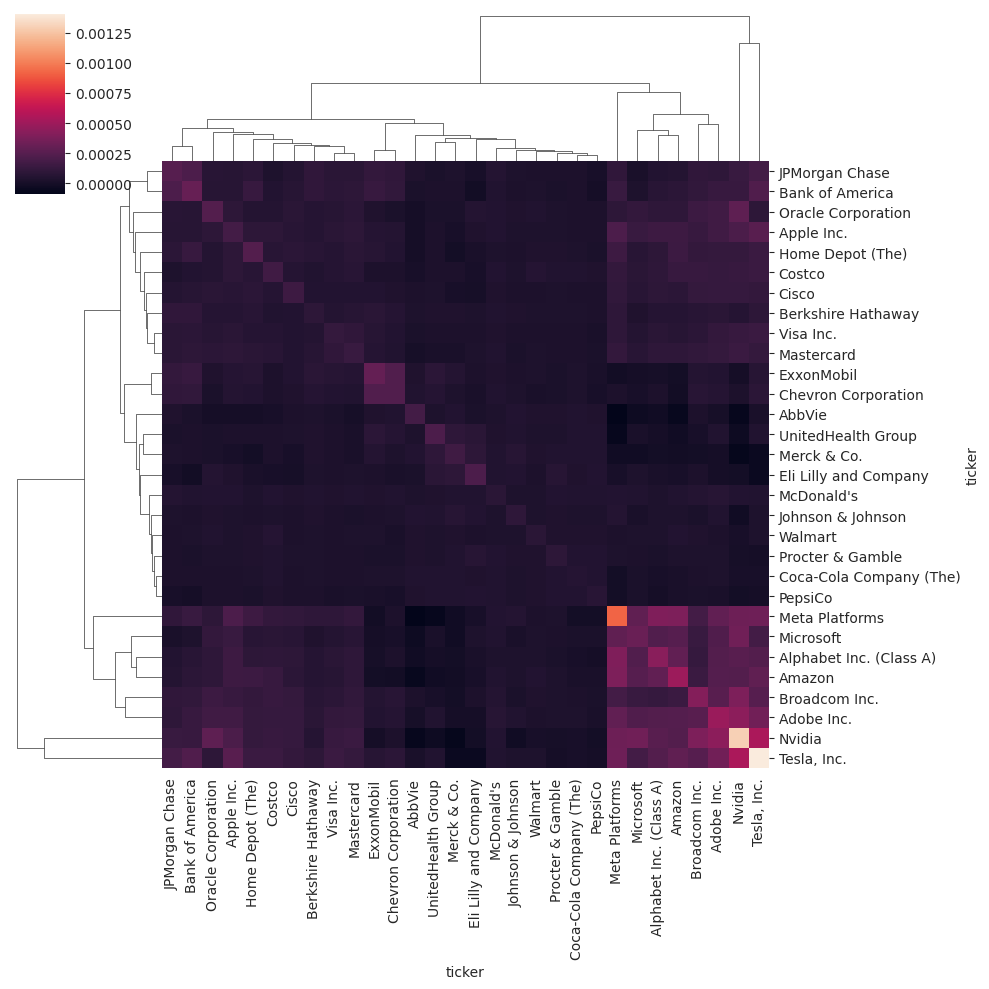

In [15]:
cov = returns.cov()
sns.clustermap(cov)

### PCA 분석 후 component별 비중
- 설명력이 높은 PCA의 components에서 weight가 높은 stock이 시장에 큰 영향을 준다.

In [16]:
pca = PCA()
pca.fit(cov)
pd.Series(pca.explained_variance_ratio_).to_frame('Explained Variance').head().style.format('{:,.2%}'.format)

,Explained Variance
0,68.37%
1,12.21%
2,9.45%
3,3.72%
4,1.46%


In [18]:
top4 = pd.DataFrame(pca.components_[:5], columns=cov.columns)
eigen_portfolios = top4.div(top4.sum(1), axis=0)
eigen_portfolios.index = [f'Portfolio {i}' for i in range(5)]

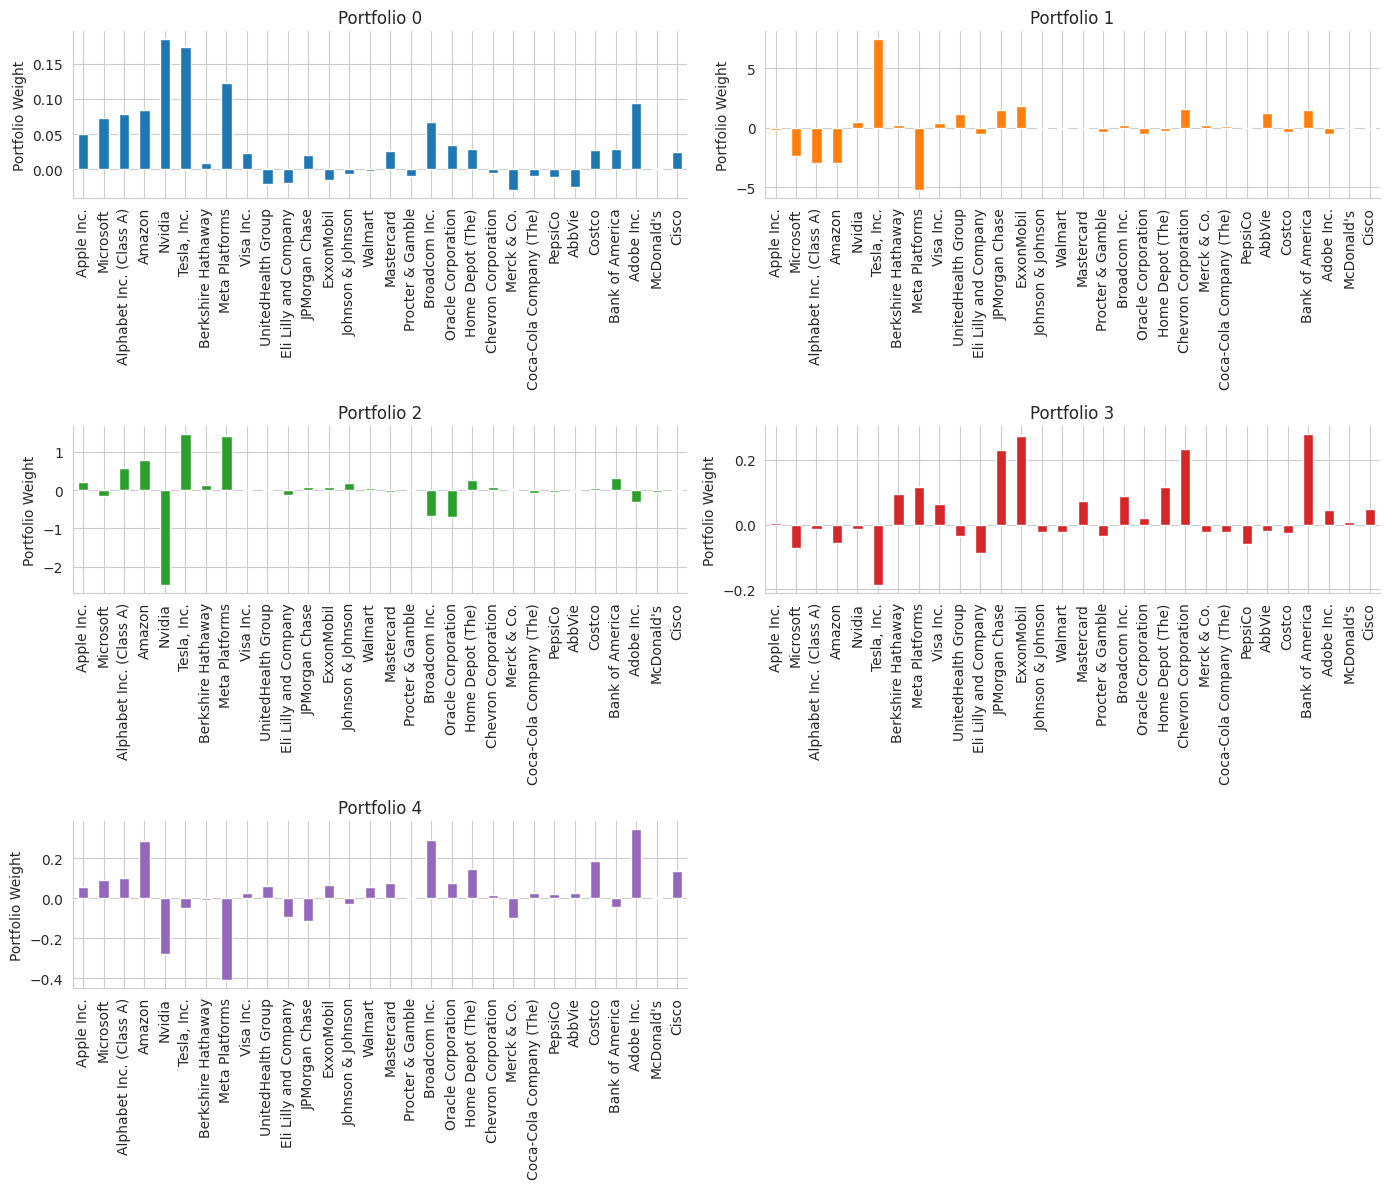

In [25]:
axes = eigen_portfolios.T.plot.bar(subplots=True,
                                   layout=(3, 2),
                                   figsize=(14, 12),
                                   legend=False,
                                   sharex=False,
                                   sharey=False)
for ax in axes.flatten():
    ax.set_ylabel('Portfolio Weight')
    ax.set_xlabel('')
sns.despine()
plt.tight_layout()

### PCA 분석 후 component별 수익률
- 시장(The market)을 기준으로 각 Porfolio가 어떻게 움직였는지 알 수 있다.
- 각 Porfolio를 모두 합하면 시장(The market)이 될 수 있다.
- Porfolio는 시장의 성향이라고 볼 수 있다.

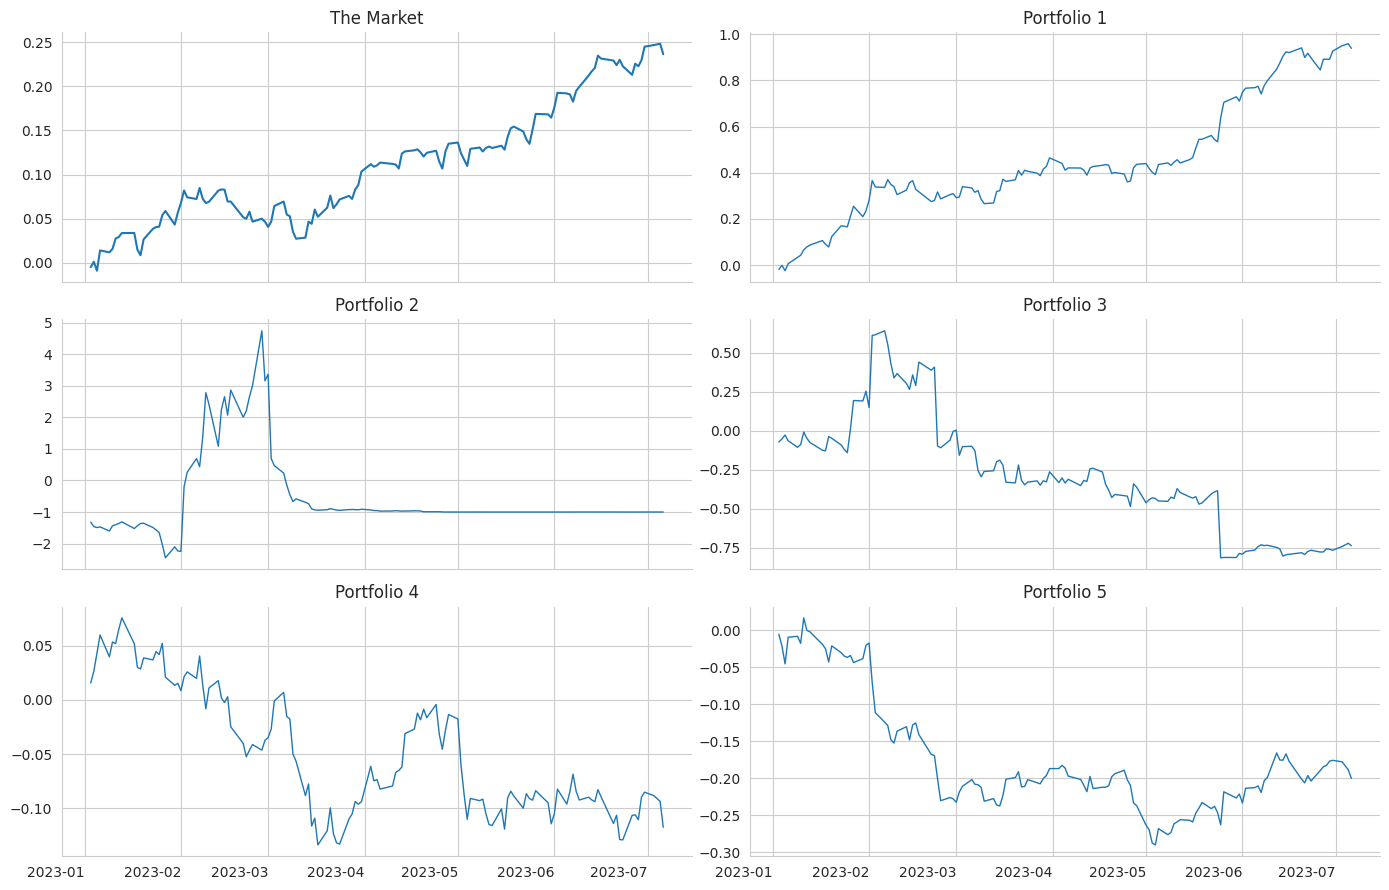

In [20]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 9), sharex=True)
axes = axes.flatten()
returns.mean(1).add(1).cumprod().sub(1).plot(title='The Market', ax=axes[0])
for i in range(5):
    rc = returns.mul(eigen_portfolios.iloc[i]).sum(1).add(1).cumprod().sub(1)
    rc.plot(title=f'Portfolio {i+1}', ax=axes[i+1], lw=1, rot=0)

for i in range(6):
    axes[i].set_xlabel('')
sns.despine()
fig.tight_layout()

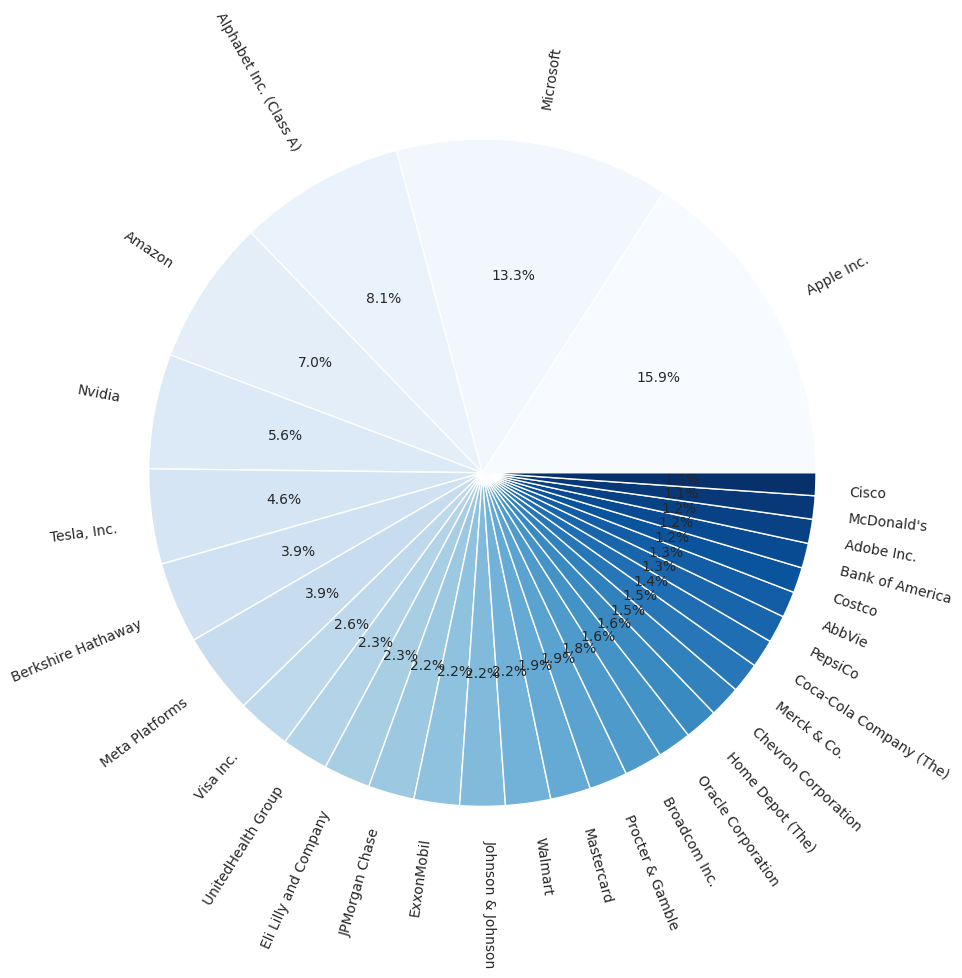

In [21]:
market_cap = market_cap.rename(index=columns)
(market_cap.sort_values(by='cap',ascending=False)/market_cap.sum())[:30].plot.pie(subplots=True, legend=False,
                                                                                  figsize=(10,10), cmap='Blues',
                                                                                  autopct='%.1f%%', fontsize=10, ylabel='',rotatelabels=True)
plt.tight_layout()